# Kelompok A2-9

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [93]:
image_path = 'emotion'
Categories = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
# Categories = sorted(os.listdir(image_path))

## Preprocessing

In [94]:
# # Image convert to array
# images = []
# for category in Categories:
#     path = os.path.join(image_path,category)
#     for i in path:
#         images.append(path)


### Split

In [95]:
train_image = image_dataset_from_directory(
    image_path,
    labels = 'inferred',
    label_mode = 'int',
    class_names = Categories,
    color_mode = 'grayscale',
    image_size = (128,128),
    shuffle = True,
    seed = 1,
    validation_split = 0.1,
    subset = 'training',
)


val_image = image_dataset_from_directory(
    image_path,
    labels = 'inferred',
    label_mode = 'int',
    class_names = Categories,
    color_mode = 'grayscale',
    image_size = (128,128),
    shuffle = True,
    seed = 1,
    validation_split = 0.1,
    subset = 'validation',
)

Found 1176 files belonging to 7 classes.
Using 1059 files for training.
Found 1176 files belonging to 7 classes.
Using 117 files for validation.


### Augmentation & Standarization

In [96]:
def augment(x,y):
    images = tf.image.random_flip_left_right(x,seed=None)
    # images = tf.image.random_flip_up_down(x, seed=None)
    return images,y

def standard(x,y) :
    images = tf.image.per_image_standardization(x)
    return images,y

In [97]:
train = train_image.map(standard)
train = train.map(augment)
validation = val_image.map(standard)
validation = validation.map(augment)

In [98]:
class_name = train_image.class_names
class_name

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

### Normalization

In [99]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32)/255, label

In [100]:
train = train.map(normalize_image)
validation = validation.map(normalize_image)

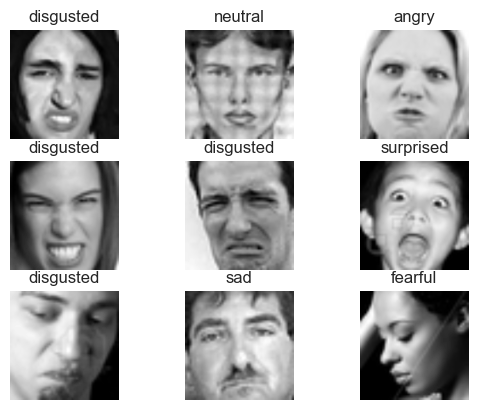

In [101]:
class_name = train_image.class_names

# plt.figure(figsize=(5, 5))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("float"), cmap='gray')
        plt.title(class_name[labels[i]])
        plt.axis("off")

## Modeling

In [102]:
model = tf.keras.Sequential([
    # Input
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=[128, 128, 1]),
    
    # Hidden
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(512, activation='softmax'),
    
    # Output
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 256)     2560      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 128)       295040    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)      

In [103]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [104]:
hasil = model.fit(train, epochs = 10, validation_data = validation, verbose=1)

Epoch 1/10
34/34 [==============================] - 104s 3s/step - loss: 1.9407 - accuracy: 0.1832 - val_loss: 1.9398 - val_accuracy: 0.1624
Epoch 2/10
34/34 [==============================] - 101s 3s/step - loss: 1.9337 - accuracy: 0.1974 - val_loss: 1.9409 - val_accuracy: 0.1624
Epoch 3/10
34/34 [==============================] - 102s 3s/step - loss: 1.9321 - accuracy: 0.1974 - val_loss: 1.9419 - val_accuracy: 0.1624
Epoch 4/10
34/34 [==============================] - 104s 3s/step - loss: 1.9311 - accuracy: 0.1974 - val_loss: 1.9429 - val_accuracy: 0.1624
Epoch 5/10
34/34 [==============================] - 102s 3s/step - loss: 1.9302 - accuracy: 0.1974 - val_loss: 1.9431 - val_accuracy: 0.1624
Epoch 6/10
34/34 [==============================] - 103s 3s/step - loss: 1.9297 - accuracy: 0.1974 - val_loss: 1.9442 - val_accuracy: 0.1624
Epoch 7/10
34/34 [==============================] - 100s 3s/step - loss: 1.9290 - accuracy: 0.1974 - val_loss: 1.9453 - val_accuracy: 0.1624
Epoch 8/10
34

## Visualisasi

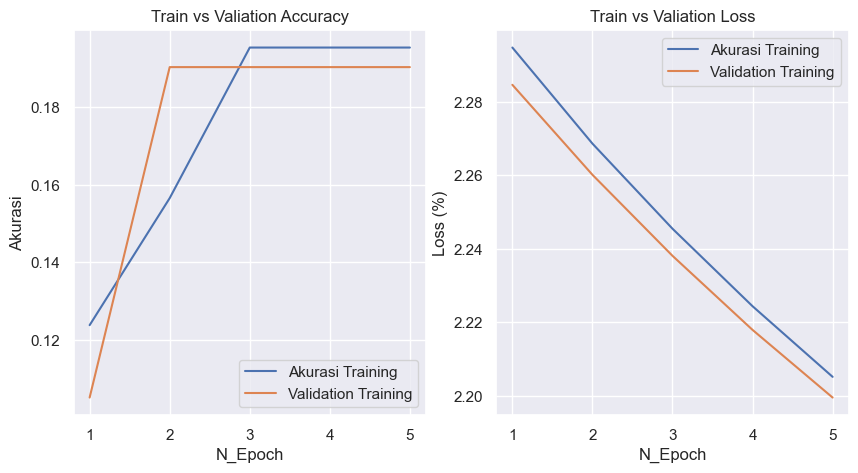

In [16]:
epochs = [i+1 for i in range(5)]

sns.set_theme()

plt.figure(figsize=(10,5))

# Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=hasil.history['accuracy'], label = 'Akurasi Training')
sns.lineplot(x=epochs, y=hasil.history['val_accuracy'], label = 'Validation Training')


plt.xticks(epochs)
plt.ylabel('Akurasi')
plt.xlabel('N_Epoch')
plt.title('Train vs Valiation Accuracy')


# Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epochs, y=hasil.history['loss'], label = 'Akurasi Training')
sns.lineplot(x=epochs, y=hasil.history['val_loss'], label = 'Validation Training')

plt.xticks(epochs)
plt.ylabel('Loss (%)')
plt.xlabel('N_Epoch')
plt.title('Train vs Valiation Loss')

plt.show()

In [17]:
evaluasi = model.evaluate(validation)
print(f'Akurasi Validation-Set : {evaluasi[1]}')
print(f'Loss Validation-Set : {evaluasi[0]}')

11/11 [==============================] - 4s 345ms/step - loss: 2.2033 - accuracy: 0.1903
Akurasi Validation-Set : 0.19034090638160706
Loss Validation-Set : 2.2032644748687744


In [18]:
print("Akurasi :", hasil.history["accuracy"][-1] * 100, "%")
print("Akurasi validasi :", hasil.history["val_accuracy"][-1] * 100, "%")

Akurasi : 19.53883469104767 %
Akurasi validasi : 19.034090638160706 %
